In [2]:
import numpy as np
import magpylib as magpy

from currio.utils import get_multipole_expansion_from_line_currents
from currio.utils import get_multipole_expansion_from_current_density
from currio.sensor import RegularGridSensor

from currio.tests.test_multipole import create_loop
import magrec
from magrec.misc.sampler import GridSampler
from magrec.misc.plot import plot_vector_field_2d
from magrec.misc.plot import get_gridspec
from magrec.misc.plot import plot_n_components


# -

In [2]:
pts, crs = create_loop(1, 1, n=300)

# get_multipole_expansion(crs, pts, order=0)
get_multipole_expansion_from_line_currents(crs, pts, order=1)

array([0.        , 0.        , 3.14136298])

In [3]:
J = np.random.normal(0, 1, (16, 3))
pts = np.random.normal(0, 1, (16, 3))

get_multipole_expansion_from_current_density(J, pts, volume_element=1, order=1)

array([ 1.33895715, -1.10356946, -2.07820291])

In [6]:
loop = magpy.current.Polyline(vertices=pts, current=1)
loop.show()

In [ ]:
Jxy = np.loadtxt('/Users/ValerioDeSio/Desktop/PythonThesis/Jxy.csv', float, delimiter=',')
Jxy.shape

(62500, 3)

In [37]:
Js = Jxy[:, 0]
current_density = np.zeros((len(Js), 3))
current_density[:, 0] = Js
xs = Jxy[:, 1]
ys = Jxy[:, 2]
pts = np.stack([xs, ys, np.zeros_like(xs)], axis=1)



In [28]:
pts[:,0].shape

(62500,)

# TODO:

For Aug 7, 2025:

1. Implement iterating through a custom grid spec over a current density and compute `get_multipole_expansion_from_current_density` on it. Return as a vector of size (`n_columns`, `n_rows`, `monopole_compoents` = 3)

Only monopole will have 3 components (_z is 0)

Function signature:

```python
def get_grid_monopole_expansion(current_density, grid_spec):
    ```
    grid_spec: a tuple with (n_columns, n_rows)
    ```
    pass
```

2. Add monopole expansion terms to the `plot_vector_field_2d` function: monopole vectors should be placed at the grid element centers and plotted with a different color and the scale bar for size (or something like this).

3. Think how time comes into play: it will be additional dimension in the input. Your J density is `(2, 3, n_time_steps)`. Return as `(2, 3, n_time_steps, monopole_components)`. 

---

4. Ask Alessandro for spiral current density.
5. Compute the monopole expansion of the spiral current density.

---

For later

MATH:

6. Read about dipole moments. 
7. Implement dipole moment calculation from current density. Use the same grid spec. 


Send Valerio:
phone number to contact me in WhatsApp
paper about multipole expansion
link to magrec and currio github repos

## Task 1

In [3]:
def get_grid_multipole_expansion(current_density, pts, grid_spec=None, cell_size=None, volume_element=1.0, order=0):
    """
    The space is divided into a 2D grid and the monopole expansion is computed in each grid cell specified either with respect to the size or the number of elements.

    Inputs:
    - current_density: array of shape (N, 3), current density vector (A/m^2)
    - pts: array of shape (N, 3), list of points between which the current is flowing
    - grid_spec (optional): tuple (n_columns, n_rows), number of grid cells along x and y
    - cell_size (optional): tuple (dx, dy), dimension of grid element

    Output:
    - grid_monopoles: array of shape (n_columns, n_rows, 3)
    - grid_centers: array of shape (n_columns, n_rows, 2), coordinates of the centers for each element of the grid
    """

    if (grid_spec is None and cell_size is None) or (grid_spec is not None and cell_size is not None):
        raise ValueError("Provide either grid_spec or cell_size.")

    xs = pts[:, 0]
    ys = pts[:, 1]

    # Box definition
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()

    Lx, Ly= x_max-x_min, y_max-y_min

    if grid_spec is not None:
        n_columns, n_rows = grid_spec
    else:
        dx, dy = cell_size
        n_columns = int(np.ceil(Lx / dx))
        n_rows = int(np.ceil(Ly / dy))

    # Grid points definition
    x_edges = np.linspace(x_min, x_max, n_columns+1)
    y_edges = np.linspace(y_min, y_max, n_rows+1)

    # Output inizialization
    grid_monopoles = np.zeros((n_columns, n_rows, 3))
    grid_centers = np.zeros((n_columns, n_rows, 2))

    for i in range(n_columns):
        for j in range(n_rows):
            x0, x1 = x_edges[i], x_edges[i+1]
            y0, y1 = y_edges[j], y_edges[j+1]

            # Store the center of the cell
            center_x = (x0 + x1) / 2
            center_y = (y0 + y1) / 2
            grid_centers[i, j] = [center_x, center_y]

            # Mask
            cell = (
                (xs >= x0) & (xs <= x1) &
                (ys >= y0) & (ys <= y1)
            )

            J_cell = current_density[cell]
            pts_cell = pts[cell]

            if J_cell.shape[0] > 0:
                grid_monopoles[i ,j] = get_multipole_expansion_from_current_density(J_cell, pts_cell, volume_element=volume_element, order=order)

    return grid_monopoles, grid_centers



In [ ]:
# Create a boolean mask for the region of interest
mask = (xs >= 1.00) & (xs <= 25.90) & (ys >= 1) & (ys <= 25.90)

# Filter pts and current_density
pts_roi = pts[mask]
J_roi = current_density[mask]

monopole = get_multipole_expansion_from_current_density(J_roi, pts_roi, volume_element=1.0, order=0)
monopole

In [ ]:
grid_monopoles, grid_centers = get_grid_multipole_expansion(current_density, pts, grid_spec=(15,15), volume_element=1.0)
grid_monopoles[0, 0, :]

array([-1.10485382,  0.        ,  0.        ])

## Task 2

In [4]:
def get_grid_multipole_expansion_time(current_density_series, pts, cell_size=None, grid_spec=None, volume_element=1.0, order=0):
    """
    Monopole expansion is computed for each element of the grid from a time series of current densities.

    Inputs:
    - current_density_series: array (N, 3, T), current density at each point over time
    - pts: array (N, 3), point coordinates
    - grid_spec (optional): tuple (n_columns, n_rows)
    - cell_size (optional): tuple (dx, dy)
    - volume_element: float

    Outputs:
    - grid_monopoles_series: array (n_columns, n_rows, T, 3)
    - grid_centers_series:  array (n_columns, n_rows, T, 2)  # centers repeated over time
    """

    _, _, T = current_density_series.shape

    if (grid_spec is None and cell_size is None) or (grid_spec is not None and cell_size is not None):
        raise ValueError("Provide either grid_spec or cell_size, not both.")

    xs = pts[:, 0]
    ys = pts[:, 1]

    # Bounding box
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    Lx, Ly = x_max - x_min, y_max - y_min

    if grid_spec is not None:
        n_columns, n_rows = grid_spec
        # (dx, dy) not strictly needed further, but computed for completeness
        dx = Lx / n_columns
        dy = Ly / n_rows
    else:
        dx, dy = cell_size
        n_columns = int(np.ceil(Lx / dx))
        n_rows   = int(np.ceil(Ly / dy))

    # Grid edges and centers
    x_edges = np.linspace(x_min, x_max, n_columns + 1)
    y_edges = np.linspace(y_min, y_max, n_rows + 1)

    # Precompute centers (time-invariant)
    grid_centers = np.zeros((n_columns, n_rows, 2))
    for i in range(n_columns):
        for j in range(n_rows):
            x0, x1 = x_edges[i],   x_edges[i + 1]
            y0, y1 = y_edges[j],   y_edges[j + 1]
            grid_centers[i, j, 0] = 0.5 * (x0 + x1)
            grid_centers[i, j, 1] = 0.5 * (y0 + y1)

    # Allocate outputs
    grid_monopoles_series = np.zeros((n_columns, n_rows, T, 3))
    # Repeat centers along time so caller can index [:, :, t, :]
    grid_centers_series = np.repeat(grid_centers[:, :, np.newaxis, :], T, axis=2)

    # Time loop
    for t in range(T):
        J_t = current_density_series[:, :, t]  # (N, 3)

        for i in range(n_columns):
            for j in range(n_rows):
                x0, x1 = x_edges[i],   x_edges[i + 1]
                y0, y1 = y_edges[j],   y_edges[j + 1]

                # Select points in the cell
                mask = (
                    (xs >= x0) & (xs <= x1) &
                    (ys >= y0) & (ys <= y1)
                )
                J_cell   = J_t[mask]
                pts_cell = pts[mask]

                if J_cell.shape[0] > 0:
                    grid_monopoles_series[i, j, t, :] = get_multipole_expansion_from_current_density(
                        J_cell, pts_cell, volume_element=volume_element, order=order
                    )

    return grid_monopoles_series, grid_centers_series
    
    

In [5]:
# Synthetic test setup
N = 5  # 4 spatial points
T = 3  # 3 time steps

# Points in a 2x2 square grid, positions fixed
pts = np.array([
    [0, 0, 0],  # bottom-left
    [0.3, 0, 0],
    [1.1, 0, 0],  # bottom-right
    [0, 1.1, 0],  # top-left
    [1.1, 1.1, 0],  # top-right
])

# Current densities for each point over 3 time steps
# Shape: (N, 3, T)
current_density_series = np.zeros((N, 3, T))

# Time step 0: all currents in +x
current_density_series[:, 0, 0] = [1, 1, 2, 3, 4]  # Jx values
# Time step 1: all currents in +y
current_density_series[:, 1, 1] = [1, 1, 2, 3, 4]  # Jy values
# Time step 2: diagonal currents
current_density_series[:, 0, 2] = [1, 1, 1, 1, 1]  # Jx
current_density_series[:, 1, 2] = [1, 0, 1, 1, 1]  # Jy

In [ ]:
grid_monopoles_series, centers = get_grid_multipole_expansion_time(current_density_series, pts, grid_spec=(2,2))

## Task 3

In [6]:
from matplotlib import gridspec

CBAR_PORTION = 0.05  # portion of width allocated to each colorbar

def get_gridspec_colormap_plot_colormap():
    """
    Returns a GridSpec with 3 columns: colormap1 | plot | colormap2
    """
    return gridspec.GridSpec(
        nrows=1, 
        ncols=3,
        width_ratios=[CBAR_PORTION, 1, CBAR_PORTION],
        wspace=0.1
    )

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import torch

def plot_vector_field_2d_monopoles(current_distribution, grid_monopoles, grid_centers, ax: plt.Axes = None, 
                         interpolation='none', cmap='plasma', monopole_cmap='viridis' ,color='black', units=None,
                         units_mono=None, title=None, show=False, num_arrows=20, zoom_in_region=None):
    """
    Visualizes the current distribution in 2D as a heatmap of magnitudes and arrows representing the flow direction.
    On top of the heatmap, the monopoles are plotted with direction given by the components and magnitude by the colormap
    
    Parameters:
    ----------
    current_distribution : ndarray
        An array of shape (2, W, H) representing current distribution vectors.

    grid_monopoles : ndarray
        An array of shape (n_columns, n_rows, 3) representing the monopoles computed for each element in the grid

    grid_centers : ndarray
        An array of shape (n_columns, n_rows, 2), representing the coordinates for the centers of each element in the grid
    
    interpolation : str, optional
        The interpolation method to be used for the heatmap. Options are as provided by matplotlib's `imshow`.
        Default is 'none'.
    
    cmap : str, optional
        The colormap to be used for the heatmap. Options are as provided by matplotlib's colormaps.
        Default is 'plasma'.

    monopole_cmap : str, optional
        The colormap to be used for the monopoles magnitude. Options are as provided by matplotlib's colormaps.
        Default is 'viridis'.

    The 'inferno' & 'cool' combination provides ease of view for the quivers with respect to the background. 
        
    color : str, optional
        The color of the arrows. Default is 'black'.
            
    units : str, optional
        Show units on the colorbar for the current distribution. Default is None (no units).

    units_mono : str, optional
        Show units on the colorbar for the monopoles magnitude. Default is None (no units).
        
    title: str, optional
        Title of the plot. Default is None (no title).
    
    show : bool, optional
        If True, the plot is displayed using `plt.show()`. Otherwise, the plot is returned without being shown.
        Default is False.
    
    num_arrows : int, optional
        The approximate number of arrows to be used for the quiver plot across the width of the image.
        The function will adjust the number of arrows to avoid overcrowding. Default is 20.
    
    zoom_in_region : tuple of two tuples, optional
        A tuple representing the top-left and bottom-right corners of the rectangle for the inset. The format is 
        ((index_x_origin, index_y_origin), (index_x_diagonal, index_y_diagonal)). If provided, the function will render 
        the specified inset region with an arrow indicating the average flow direction. Default is None.
    
    Returns:
    -------
    fig : Figure
        A matplotlib figure containing the visualizations.

    Notes:
    -----
    - The main visualization provides a heatmap of the magnitudes and arrows indicating the flow direction of the 
      current distribution, and on top of that the arrows for the monopoles computed are plotted with the magnitude given by the colormap.
    - The inset, if specified, provides a zoomed-in view of a particular region of the main visualization, allowing for 
      a closer inspection of details.

    Examples:
    --------
    >>> dist = np.random.rand(2, 100, 100)
    >>> fig = plot_vector_field_2d(dist, interpolation='bilinear', cmap='inferno', show=True, num_arrows=30, inset_region=((20, 20), (40, 40)))
    """  
    # PARAMS
    # figsize = get_figsize(n_components=1, n_maps=1, alignment='horizontal')
    
    # Create a figure with an axis if none is provided
    if ax is None:
        fig = plt.figure(frameon=False)
        gs = get_gridspec_colormap_plot_colormap()

        # Main plot
        ax = fig.add_subplot(gs[1])

        # Main plot position
        ax_pos = ax.get_position()

        # Customization parameters
        cbar_height_ratio = 0.7  
        cbar_width = 0.03      
        cbar_padding = 0.1    

        # The colorbars are positioned with respect to the center of the plot
        ax_center_y = ax_pos.y0 + 0.5 * ax_pos.height
        cbar_height = ax_pos.height * cbar_height_ratio
        cbar_bottom = ax_center_y - 0.5 * cbar_height

        left_cbar_x = ax_pos.x0 - cbar_width - cbar_padding
        cax_left = fig.add_axes([left_cbar_x, cbar_bottom, cbar_width, cbar_height])

        right_cbar_x = ax_pos.x1 + cbar_padding
        cax_right = fig.add_axes([right_cbar_x, cbar_bottom, cbar_width, cbar_height])
    else:
        fig = ax.get_figure()
        try:
            cax_right = ax.cax2
            cax_left = ax.cax1
        except AttributeError:
            divider = make_axes_locatable(ax)
            cax_right = divider.append_axes("right", size="5%", pad=0.05)
            cax_left = divider.append_axes("left", size="5%", pad=0.05)

        
    if isinstance(current_distribution, torch.Tensor):
        current_distribution = current_distribution.detach().cpu().numpy()
        
    W, H = current_distribution.shape[-2:]
    step_size = max(W, H) // num_arrows
    
    # Create averaged grid
    x_centers = np.arange(step_size // 2, W, step_size)
    y_centers = np.arange(step_size // 2, H, step_size)
    
    x_grid, y_grid = np.meshgrid(x_centers, y_centers, indexing='ij')
    
    # Initialize averaged fields
    avg_u = np.zeros((len(x_centers), len(y_centers)))
    avg_v = np.zeros((len(x_centers), len(y_centers)))
    avg_m = np.zeros((len(x_centers), len(y_centers)))
    
    # Loop through and average
    for i, x in enumerate(x_centers):
        for j, y in enumerate(y_centers):
            x_low, x_high = x - step_size // 2, x + step_size // 2 + 1
            y_low, y_high = y - step_size // 2, y + step_size // 2 + 1
            
            avg_u[i, j] = np.mean(current_distribution[0, x_low:x_high, y_low:y_high])
            avg_v[i, j] = np.mean(current_distribution[1, x_low:x_high, y_low:y_high])
            avg_m[i, j] = np.sqrt(avg_v[i, j] ** 2 + avg_u[i, j] ** 2)
    
    magnitudes = np.hypot(current_distribution[0], current_distribution[1]).transpose(1, 0)
    
    im = ax.imshow(magnitudes, interpolation=interpolation, vmin=0, cmap=cmap, origin='lower')
    
    cbar = fig.colorbar(im, cax=cax_left, orientation='vertical')
    cax_left.yaxis.set_ticks_position('left')
    cax_left.yaxis.set_label_position('left')
    if units:
        cax_left.set_title(f"Current field [{units}]", fontsize=9, loc='center')
        
    if title:
        if isinstance(title, str):
            # Use .annotate() method to add the title text at the top of the figure
            ax.annotate(title, xy=(0.5, 1.1), xycoords='axes fraction',
                        xytext=(0, 0), textcoords='offset points',
                        ha='center', va='baseline')
    
    # Compute scale of the arrow length. 
    # Scale gives number of data points per arrow length unit, 
    # e.g. A/mm^2 per plot width. We want the maximum arrow length to be 1/num_arrows of the plot width.
    # How much data units per arrow length unit? 
    scale = 1.1 * avg_m.max() * num_arrows  # 1.1 to make the length of the longest arrow a bit shorter 
                                            # than the spacing between arrows blocks.  
    
    ax.quiver(
        x_grid, y_grid, avg_u, avg_v, color=color,
        pivot='mid', units='width', angles='uv',
        scale=scale, scale_units='width',
    )
    
    # --- Monopole Quivers ---
    X = grid_centers[:, :, 0].flatten()
    Y = grid_centers[:, :, 1].flatten()
    U = grid_monopoles[:, :, 0].flatten()
    V = grid_monopoles[:, :, 1].flatten()
    W = grid_monopoles[:, :, 2].flatten()
    magnitudes_mono = np.sqrt(U**2 + V**2 + W**2)

    # To avoid overcrowding of the plot, the quivers for the monopoles direction have a length that is half the distance with the nearest 
    # element of the cell
    dx = np.mean(np.diff(grid_centers[:, 0, 0]))  
    dy = np.mean(np.diff(grid_centers[0, :, 1]))  

    spacing = min(dx, dy)

    # Normalize direction
    norms_xy = np.sqrt(U**2 + V**2)
    U_norm = np.divide(U, norms_xy, out=np.zeros_like(U), where=norms_xy != 0)
    V_norm = np.divide(V, norms_xy, out=np.zeros_like(V), where=norms_xy != 0)

    # Fixed arrow length
    arrow_length = spacing * 0.5 # The value can be tweaked according to preference
    U_fixed = U_norm * arrow_length
    V_fixed = V_norm * arrow_length

    # Plot arrows e
    q = ax.quiver(
        X, Y, U_fixed, V_fixed, magnitudes_mono,
        cmap=monopole_cmap,
        scale_units='xy',  
        scale=1,          
        width=0.004,
        headlength=6,
        headaxislength=5,
        headwidth=4
)

    
    cb2 = fig.colorbar(q, cax=cax_right, orientation='vertical')
    if units_mono:
        cax_right.set_title(f"Monopole [{units_mono}]", fontsize=9, loc='center')

    if zoom_in_region is not None:
        x0, y0 = zoom_in_region[0]
        x1, y1 = zoom_in_region[1]
        axins = inset_axes(ax, width="30%", height="30%", loc='upper left')
        axins.imshow(magnitudes[x0:x1, y0:y1], cmap=cmap, origin='lower')
        
        axins.set_xticks([])
        axins.set_yticks([])
        
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal')
    
    if not show:
        plt.close()
        
    return fig



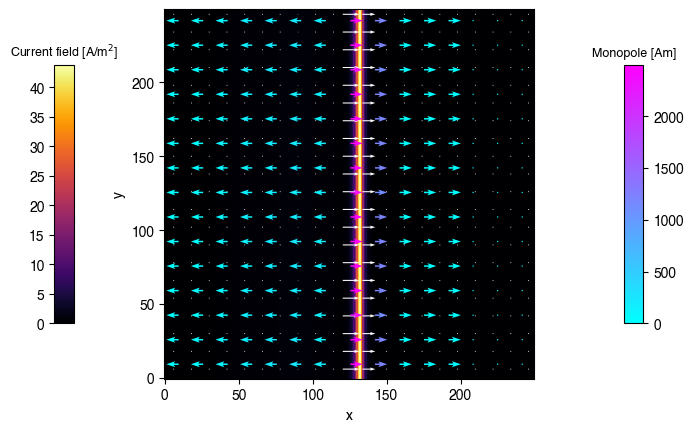

In [155]:
plot_vector_field_2d_monopoles(GridSampler.pts_to_grid(current_density, 250, 250)[0:2, :, :].permute(0, 2, 1), grid_monopoles, grid_centers, color='white', units=r'A/m$^2$', units_mono=r'Am', monopole_cmap='cool', cmap='inferno')

## Task 4

In [8]:
def time_shifted_plane_wave(J, shift_px=1, T=30, axis='x'):
    """
    Create a time series J(x,y,t) by spatially shifting J(x,y). Only works for plane waves
     
    Inputs:
    Jxy: array of shape (N,3), with columns Jx (or Jy), x and y
    shift_px (optional): scalar value that indicates how many pixels (grid points) to shift the current for time step. Standard value is 1
    T (optional): scalar value that indicates how many time steps are created. Standard value is 30
    axis (optional): string that indicates the axis where shifting happens, i.e. the axis along which the wave propagates

    Outputs:
    current_density_series: array of shape (N,3,t), gives the current density expanded in time
    pts: array of shape (N,3), gives every combination of grid points (e.g. if the grid is 250x250 with a resolution of 1, then N=62500). The z component is neglected
    """
    # --- unpack input ---
    Js = J[:, 0]             # current along x (your file uses this convention)
    xs = J[:, 1]
    ys = J[:, 2]

    # infer grid
    x_vals = np.unique(xs)
    y_vals = np.unique(ys)
    nx, ny = len(x_vals), len(y_vals)
    N = nx*ny
    assert N == len(Js), "Points do not look like a regular grid."

    # order points by (y, then x) to reshape to [ny, nx]
    order = np.lexsort((xs, ys))          # primary key = ys, secondary = xs
    inv_order = np.empty_like(order)
    inv_order[order] = np.arange(N)

    Js_grid = Js[order].reshape(ny, nx)

    # choose roll axis
    roll_axis = 1 if axis.lower() == 'x' else 0

    # allocate time series (N, 3, T); only Jx is nonzero here
    current_density_series = np.zeros((N, 3, T), dtype=Js.dtype)

    for t in range(T):
        shift = t * shift_px
        Js_t_grid = np.roll(Js_grid, shift=shift, axis=roll_axis)  # wrap-around shift

        # flatten back to original point order
        Js_t_flat = Js_t_grid.reshape(N)[inv_order]

        # fill Jx component, Jy,Jz = 0
        current_density_series[:, 0, t] = Js_t_flat

    # pts (x,y,0) unchanged
    pts = np.stack([xs, ys, np.zeros_like(xs)], axis=1)
    return current_density_series, pts


In [ ]:
# build a 60-frame time series that shifts 2 pixels right every frame
current_density_series, pts = time_shifted_plane_wave(
    Jxy, shift_px=2, T=100, axis='x'
)

grid_monopoles_series, grid_centers_time = get_grid_multipole_expansion_time(current_density_series, pts, grid_spec=(15,15))

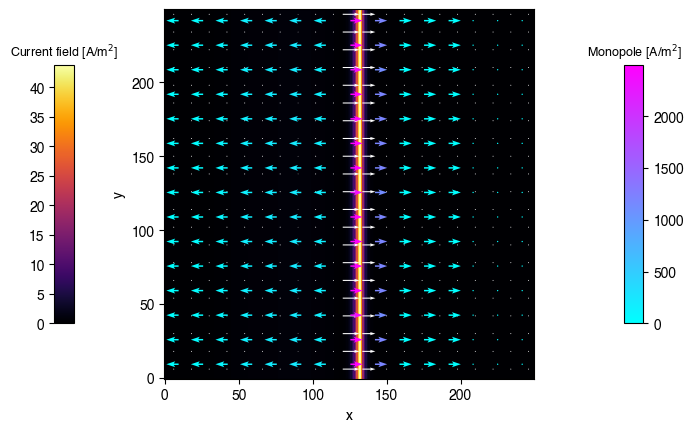

In [48]:
cds = current_density_series[:,:,0]
gds = grid_monopoles_series[:,:,0]
gcs = grid_centers_time[:,:,0]

plot_vector_field_2d_monopoles(GridSampler.pts_to_grid(cds, 250, 250)[0:2, :, :].permute(0, 2, 1), gds, gcs, color='white', units=r'A/m$^2$', units_mono=r'A/m$^2$', monopole_cmap='cool', cmap='inferno')

## Task 5

In [9]:
def get_grid_multipole_expansion_time_3d(current_density_series, pts,
                                        cell_size=None, grid_spec=None,
                                        volume_element=None, order=0):
    """
    Compute monopole expansion for each 3D cell (voxel) from time series of current densities. 

    Inputs:
    - current_density_series: (N, 3, T) array, current density at each point over time
    - pts: (N, 3) array, point coordinates
    - grid_spec (optional): (nx, ny, nz) number of cells along each axis
    - cell_size (optional): (dx, dy, dz) size of each cell
    - volume_element: float, volume per sample

    Outputs:
    - grid_monopoles_series: (nx, ny, nz, T, 3)
    - grid_centers_series: (nx, ny, nz, T, 3) centers repeated along time
    """

    _, _, T = current_density_series.shape

    if (grid_spec is None and cell_size is None) or (grid_spec is not None and cell_size is not None):
        raise ValueError("Provide either grid_spec or cell_size, not both.")

    xs, ys, zs = pts[:, 0], pts[:, 1], pts[:, 2]
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    z_min, z_max = zs.min(), zs.max()
    Lx, Ly, Lz = x_max - x_min, y_max - y_min, z_max - z_min

    if grid_spec is not None:
        nx, ny, nz = grid_spec
        dx = Lx / nx
        dy = Ly / ny
        dz = Lz / nz
    else:
        dx, dy, dz = cell_size
        nx = int(np.ceil(Lx / dx))
        ny = int(np.ceil(Ly / dy))
        nz = int(np.ceil(Lz / dz))

    # Edges and centers
    x_edges = np.linspace(x_min, x_max, nx + 1)
    y_edges = np.linspace(y_min, y_max, ny + 1)
    z_edges = np.linspace(z_min, z_max, nz + 1)

    grid_centers = np.zeros((nx, ny, nz, 3))
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                grid_centers[i, j, k, 0] = 0.5 * (x_edges[i] + x_edges[i+1])
                grid_centers[i, j, k, 1] = 0.5 * (y_edges[j] + y_edges[j+1])
                grid_centers[i, j, k, 2] = 0.5 * (z_edges[k] + z_edges[k+1])

    grid_monopoles_series = np.zeros((nx, ny, nz, T, 3))
    grid_centers_series = np.repeat(grid_centers[:, :, :, np.newaxis, :], T, axis=3)

    for t in range(T):
        J_t = current_density_series[:, :, t]  # (N, 3)
        for i in range(nx):
            for j in range(ny):
                for k in range(nz):
                    mask = (
                        (xs >= x_edges[i]) & (xs <= x_edges[i+1]) &
                        (ys >= y_edges[j]) & (ys <= y_edges[j+1]) &
                        (zs >= z_edges[k]) & (zs <= z_edges[k+1])
                    )
                    if np.any(mask):
                        r0_cell = grid_centers[i, j, k, :]
                        grid_monopoles_series[i, j, k, t, :] = get_multipole_expansion_from_current_density(
                            J_t[mask], pts[mask], volume_element=volume_element, order=order, r0=r0_cell
                        )

    return grid_monopoles_series, grid_centers_series


In [10]:
def rescale_centers_to_index(grid_centers_xy, x_vals, y_vals, *, origin_lower=True, clip=True):
    """
    Map physical (x,y) centers to image index space [0..nx-1]x[0..ny-1]. The plot is given in the index space rather than in cartesian coordinates

    grid_centers_xy : (..., 2) array with [x, y] per center (slice already chosen).
    x_vals, y_vals  : 1D arrays of the coordinates used in the grid.
    origin_lower    : True if the plot has origin='lower' (matplotlib default for imshow with origin='lower'), otherwise False.
    """
    xs_unique = np.asarray(x_vals)
    ys_unique = np.asarray(y_vals)
    if xs_unique.size == 0 or ys_unique.size == 0:
        raise ValueError("x_vals / y_vals are empty")
    nx, ny = len(xs_unique), len(ys_unique)

    x_min, x_max = xs_unique.min(), xs_unique.max()
    y_min, y_max = ys_unique.min(), ys_unique.max()
    dx = (x_max - x_min)
    dy = (y_max - y_min)

    gc = np.asarray(grid_centers_xy, dtype=float).copy()
    # x index grows left→right
    gc[..., 0] = (gc[..., 0] - x_min) / dx * (nx - 1)

    # y index: choose direction based on plotting origin
    if origin_lower:
        # y increases bottom→top (imshow(origin='lower'))
        gc[..., 1] = (gc[..., 1] - y_min) / dy * (ny - 1)
    else:
        # y increases top→bottom
        gc[..., 1] = (y_max - gc[..., 1]) / dy * (ny - 1)

    if clip:
        gc[..., 0] = np.clip(gc[..., 0], 0, nx - 1)
        gc[..., 1] = np.clip(gc[..., 1], 0, ny - 1)
    return gc


In [75]:
N = 121203 # Number of points
T = 151 # Time steps

# shape is (N, 3*T)
current_density_series_flat = np.loadtxt("/Users/ValerioDeSio/Desktop/PythonThesis/current_density_series2.csv", delimiter=",")

# Reshape to (N, 3, T)
cds = current_density_series_flat.reshape(N, 3, T, order="F")  # ← key fix

pts = np.loadtxt("/Users/ValerioDeSio/Desktop/PythonThesis/pts2.csv", delimiter=",")

# unique sorted coordinates
x_u = np.unique(np.round(pts[:,0], 12))
y_u = np.unique(np.round(pts[:,1], 12))
z_u = np.unique(np.round(pts[:,2], 12))

# grid spacings (robust: median of diffs)
dx = np.median(np.diff(x_u))
dy = np.median(np.diff(y_u))
dz = np.median(np.diff(z_u))

volume_element = dx*dy*dz

print(pts.shape)
print(cds.shape)


(121203, 3)
(121203, 3, 151)


In [76]:
gds, gcs = get_grid_multipole_expansion_time_3d(
    cds,
    pts,
    grid_spec=(19,19,1),  # 3D grid spec (x, y,z)
    volume_element=volume_element
)

# Mask for z=0.0001 plane (midplane)
mask_z0 = np.isclose(pts[:, 2], 0.0001, atol=1e-12)

# Apply mask
pts_z0 = pts[mask_z0]
cds_z0 = cds[mask_z0]  # shape: (N_z0, 3, T)

z_centers = gcs[:, :, :, 0, 2]
z_idx = np.where(np.isclose(z_centers[0, 0, :], 0.0001, atol=1e-12))[0]
z_idx = z_idx[0]

gds_z0 = gds[:, :, z_idx, :, :]
gcs_z0 = gcs[:, :, z_idx, :, :]

In [23]:
t_idx = 50 # Change according to the time step we evaluate
cds_t = cds_z0[:,:,t_idx]
gds_t = gds_z0[:,:,t_idx]
gcs_t = gcs_z0[:,:,t_idx]

In [24]:
xs_unique = np.unique(np.round(pts_z0[:, 0], 12))
ys_unique = np.unique(np.round(pts_z0[:, 1], 12))

grid_centers_idx = rescale_centers_to_index(gcs_t, xs_unique, ys_unique)

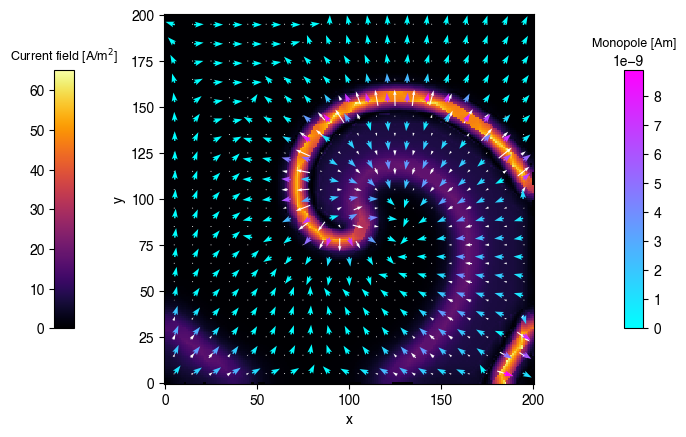

In [25]:
plot_vector_field_2d_monopoles(GridSampler.pts_to_grid(cds_t, 201, 201)[0:2, :, :], gds_t, grid_centers_idx, color='white', units=r'A/m$^2$', units_mono=r'Am', monopole_cmap='cool', cmap='inferno')

In [ ]:
import os

out_dir = "frames_mono"             
os.makedirs(out_dir, exist_ok=True)

t_start, t_end, t_step = 0, 150, 1        



for t_idx in range(t_start, t_end+1, t_step):
    # current-density grid (2, W, H) in index space
    cds_t = cds_z0[:,:,t_idx]                                        # (N_z, 3)
    cds_grid = GridSampler.pts_to_grid(torch.tensor(cds_t[:,0:2]),
                                       201, 201)              # (2, nx, ny)
    cds_grid = cds_grid.numpy()                                     # to ndarray

    # monopoles & centers at this time
    gds_t = gds[:,:,z_idx,t_idx,:]                                  # (nx_m, ny_m, 3)
    gcs_idx = grid_centers_idx                                 # (nx_m, ny_m, 2), already mapped

    # Figure
    fig = plot_vector_field_2d_monopoles(
        current_distribution = cds_grid,                # (2, nx, ny)
        grid_monopoles       = gds_t,                   # (nx_m, ny_m, 3)
        grid_centers         = gcs_idx,                 # (nx_m, ny_m, 2) IN INDEX SPACE
        interpolation='none',
        cmap='inferno',
        monopole_cmap='cool',
        color='white',
        units=r'A/m$^2$',
        units_mono=r'A·m',
        title=f't = {t_idx}',
        show=True,            
        num_arrows=25
    )

    # Save the frame
    frame_path = os.path.join(out_dir, f"frame_{t_idx:04d}.png")
    fig.savefig(frame_path, dpi=150, bbox_inches='tight')
    plt.close(fig)

print(f"Saved frames to: {out_dir}")

# magick notebooks/frames_mono/frame_*.png monopoles.gif

Saved frames to: frames_mono


## Task 6

In [ ]:
def get_b_from_monopoles_to_grid(grid_centers_series, grid_monopole_series, obs_pts, Nx, Ny):
    """
    Computes the magnetic field from the monopoles
    
    Inputs: 
    - grid_centers_series : ndarray, array of size (nx, ny, nz, T, 3). 
    - grid_monopole_series: ndarray, array of size (nx, ny, nz, T, 3).
    - obs_pts : ndarray, array of size (Nx*Ny, 3), sensor grid points (time-independent)
    
    Output:
    - B_grid : ndarray, array of size (3, Nx, Ny, T), magnetic field in T
    """

    MU0_OVER_4PI = 1e-7
    nx, ny, nz, T, _ = grid_monopole_series.shape
    N = nx * ny * nz
    M = obs_pts.shape[0]
    assert M == Nx*Ny, "obs_pts must match Nx*Ny"

    # Flatten sources to (N, T, 3)
    m_flat  = grid_monopole_series.reshape(N, T, 3)
    r0_flat = grid_centers_series.reshape(N, T, 3)

    # Centers are constant over time so grid_center_series(t0)=grid_center_series(t)

    R = obs_pts[None, :, :] - r0_flat[:, 0, :][:, None, :]   # (N, M, 3)
    R2  = np.sum(R*R, axis=2)                                # (N, M)
    R32 = (R2) * np.sqrt(R2)                                 # (N, M)

    B = np.empty((M, 3, T), dtype=m_flat.dtype)
    for t in range(T):
        mt = m_flat[:, t, :]                                 # (N, 3)
        m_cross_R = np.cross(mt[:, None, :], R, axis=2)      # (N, M, 3)
        Bt = (m_cross_R / R32[..., None]).sum(axis=0)        # (M, 3)
        B[:, :, t] = MU0_OVER_4PI * Bt

    return B.transpose(1,0,2).reshape(3, Nx, Ny, T)

In [77]:
z_sensor = max(z_u) + 2e-3

x_min, x_max = min(x_u), max(x_u)
y_min, y_max = min(y_u), max(y_u)

# Center of the slab
x0 = 0.5 * (x_min + x_max)
y0 = 0.5 * (y_min + y_max)

# NV size
FOVx = 2e-2
FOVy = 2e-2

# Resolution
Nx = 201
Ny = 201

bounds = (x0-FOVx/2, x0+FOVx/2,
          y0-FOVy/2, y0+FOVy/2, 
          z_sensor, z_sensor)

sensor = RegularGridSensor(bounds=bounds, resolution=(Nx, Ny, 1))
obs_pts = sensor.points

In [78]:
B_grid = get_b_from_monopoles_to_grid(gcs, gds, obs_pts, Nx, Ny)

In [79]:
B_grid.shape

(3, 201, 201, 151)

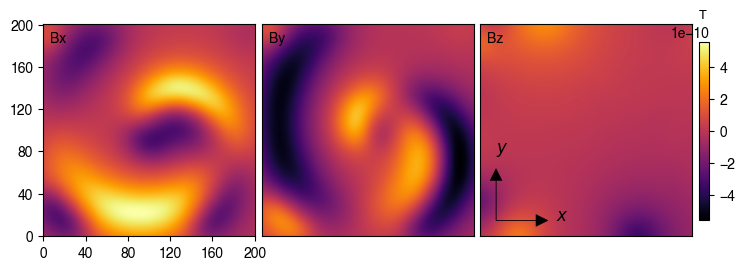

In [157]:
t_idx = 150
Bx, By, Bz = B_grid[0,:,:,t_idx], B_grid[1,:,:,t_idx], B_grid[2,:,:,t_idx]

data=np.stack([Bx,By,Bz], axis=0)

fig = plot_n_components(
    data,
    units='T',
    cmap='inferno',
    labels=['Bx','By','Bz'],
    alignment='horizontal',
    symmetric=True,
    show=True
)

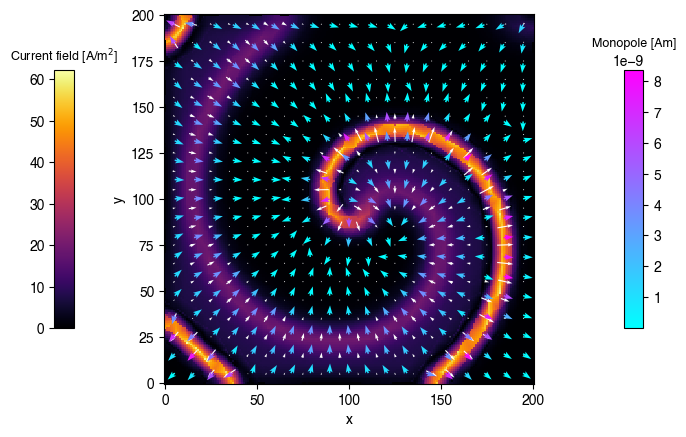

In [48]:
cds_t = cds_z0[:,:,t_idx]
gds_t = gds_z0[:,:,t_idx]
gcs_t = gcs_z0[:,:,t_idx]

plot_vector_field_2d_monopoles(GridSampler.pts_to_grid(cds_t, 201, 201)[0:2, :, :], gds_t, grid_centers_idx, color='white', units=r'A/m$^2$', units_mono=r'Am', monopole_cmap='cool', cmap='inferno')

## Task 7

In [ ]:
def grid_graph_from_monopoles(grid_centers):
    """
    Build upright square lattice (grid graph) connections from a static 2D grid of 3D points. Assume they are sorted. The grid is generated as the
    cartesian graph product of the path graphs

    Input:
    - grid_centers: ndarray, array of size (n_rows, n_cols, n_frames, 3). Grid of static 3D points.

    Output:
    - edges: list of ((x1, y1, z1), (x2, y2, z2)) tuples. Edges connecting each point to its right and top neighbors.
    """
    
    n_rows, n_cols, _, _ = grid_centers.shape
    edges = []
    
    # Only use frame 0 since all are equal
    grid = grid_centers[:, :, 0, :]

    for i in range(n_rows):
        for j in range(n_cols):
            p = grid[i, j]

            # Right neighbor
            if j + 1 < n_cols:
                p_right = grid[i, j + 1]
                edges.append((p, p_right))
            
            # Top neighbor
            if i + 1 < n_rows:
                p_top = grid[i + 1, j]
                edges.append((p, p_top))
    
    return edges


In [159]:
gds, gcs = get_grid_multipole_expansion_time_3d(
    cds,
    pts,
    grid_spec=(5,5,1),  # 3D grid spec (x, y,z)
    volume_element=volume_element
)

# Mask for z=0.0001 plane (midplane)
mask_z0 = np.isclose(pts[:, 2], 0.0001, atol=1e-12)

# Apply mask
pts_z0 = pts[mask_z0]
cds_z0 = cds[mask_z0]  # shape: (N_z0, 3, T)

z_centers = gcs[:, :, :, 0, 2]
z_idx = np.where(np.isclose(z_centers[0, 0, :], 0.0001, atol=1e-12))[0]
z_idx = z_idx[0]

gds_z0 = gds[:, :, z_idx, :, :]
gcs_z0 = gcs[:, :, z_idx, :, :]

In [160]:
edges = grid_graph_from_monopoles(gcs_z0)

In [153]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_grid_and_slab(bounds, gcs_z0, edges, frame=0, alpha=0.15):
    
    xmin, xmax, ymin, ymax, zmin, zmax = bounds
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Draw the slab (as 6 faces of a cuboid)
    corners = np.array([
        [xmin, ymin, zmin],
        [xmax, ymin, zmin],
        [xmax, ymax, zmin],
        [xmin, ymax, zmin],
        [xmin, ymin, zmax],
        [xmax, ymin, zmax],
        [xmax, ymax, zmax],
        [xmin, ymax, zmax],
    ])

    faces = [
        [corners[j] for j in [0, 1, 2, 3]],  # bottom
        [corners[j] for j in [4, 5, 6, 7]],  # top
        [corners[j] for j in [0, 1, 5, 4]],  # front
        [corners[j] for j in [2, 3, 7, 6]],  # back
        [corners[j] for j in [1, 2, 6, 5]],  # right
        [corners[j] for j in [0, 3, 7, 4]],  # left
    ]

    slab = Poly3DCollection(faces, facecolors='gray', linewidths=1,
                            edgecolors='gray', alpha=alpha)
    ax.add_collection3d(slab)

    # Plot the grid points at the selected frame
    grid = gcs_z0[:, :, frame, :]
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            x, y, z = grid[i, j]
            ax.scatter(x, y, z, c='red', s=20)

    # Plot the edges
    for p1, p2 in edges:
        xs, ys, zs = zip(p1, p2)
        ax.plot(xs, ys, zs, color='blue')

    # Axes and aesthetics
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_zlim(zmin, zmax)
    ax.set_box_aspect([1, 1, 0.1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])               # Hide tick marks

    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    ax.xaxis._axinfo['grid'].update(color = (1,1,1,0))  # Make X grid invisible
    ax.yaxis._axinfo['grid'].update(color = (1,1,1,0))  # Make Y grid invisible
    ax.zaxis._axinfo['grid'].update(color = (1,1,1,0))  # Make Z grid invisible
    
    plt.show()

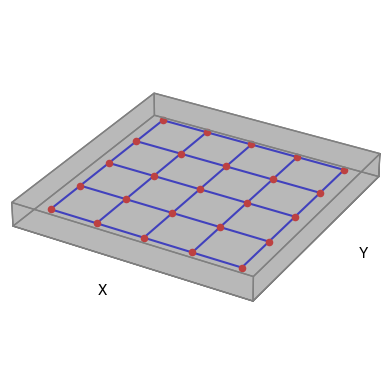

In [155]:
bounds = (min(x_u), max(x_u), min(y_u), max(y_u), min(z_u), max(z_u))

edges = grid_graph_from_monopoles(gcs_z0)

# Step 2: Plot everything
plot_grid_and_slab(bounds, gcs_z0, edges, alpha=0.3)

# -

In [ ]:
get_multipole_expansion_from_current_density(current_density, pts, volume_element=1, order=0)

array([42642.41480104,     0.        ,     0.        ])

In [36]:
get_multipole_expansion_from_current_density(current_density, pts, volume_element=1, order=1)

array([       0.        ,        0.        , -2675811.52876557])

In [ ]:
# Get dipole moment of a current wire
N = 100
currents = np.stack([np.ones(N), np.zeros(N), np.zeros(N)], axis=1)
xs, ys = np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))
pts = np.stack([xs, ys, np.zeros_like(xs)], axis=2)
pts = pts.reshape(-1, 3)
r0 = np.array([0, 0, 0])

order = 1
result = get_multipole_expansion_from_line_currents(currents, pts, order, r0=np.array([0, 0, 0]))
print(result)

In [ ]:
currents.shape

(100, 3)

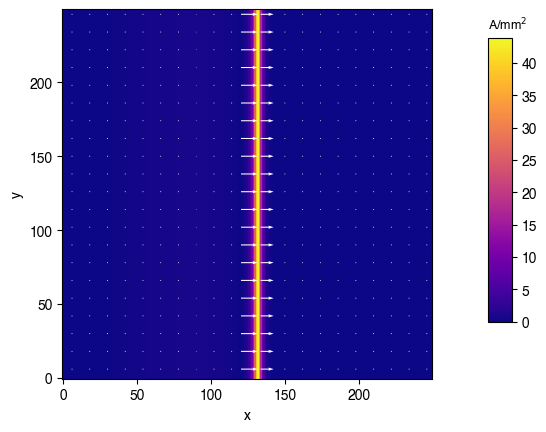

In [32]:
plot_vector_field_2d(GridSampler.pts_to_grid(current_density, 250, 250)[0:2, :, :].permute(0, 2, 1), color='white', units=r'A/mm$^2$')

In [8]:
loop = magpy.current.Circle(current=1, diameter=1)

loop.show()

In [7]:
loop = magpy.current.Circle(current=1, diameter=1)

loop.show()